In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision

In [ ]:
!pip show torch torchvision

Name: torch
Version: 2.1.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: fastai, torchaudio, torchdata, torchtext, torchvision
---
Name: torchvision
Version: 0.16.0+cu121
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, requests, torch
Required-by: fastai


In [ ]:
!pip show opendatasets

In [ ]:
!pip install opendatasets

In [ ]:
!pip show opendatasets

Name: opendatasets
Version: 0.1.22
Summary: A curated collection of datasets for data analysis & machine learning, downloadable with a single Python command
Home-page: https://github.com/JovianML/opendatasets
Author: Jovian.ml
Author-email: hello@jovian.ml
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: click, kaggle, tqdm
Required-by: 


In [ ]:
import opendatasets as od
dataset_url = 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/kbvssyjhcj-1.zip'
od.download(dataset_url)

395345920it [00:16, 24134331.97it/s]                               


In [ ]:
import shutil
directory_path = '/content/sample_data'
shutil.rmtree(directory_path)

In [ ]:
import zipfile

with zipfile.ZipFile('/content/kbvssyjhcj-1.zip', 'r') as main_zip:
    main_zip.extractall('/content/')

In [ ]:
with zipfile.ZipFile('/content/kbvssyjhcj-1/Thermal Dataset.zip', 'r') as inner_zip:
    inner_zip.extractall('/content/')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
crack_images = os.listdir('/content/ThermalDataset/Positive')
print("Number of Crack Images: ", len(crack_images))

Number of Crack Images:  5494


In [ ]:
no_crack_images = os.listdir('/content/ThermalDataset/Negative')
print("Number of No Crack Images: ", len(no_crack_images))

Number of No Crack Images:  5651


*****************Random Images with Cracks**************************


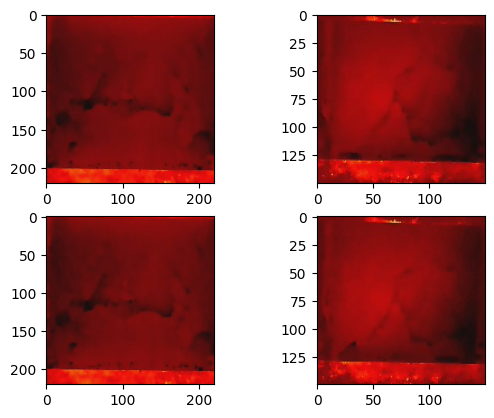

In [ ]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Positive/', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Positive/', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Positive/', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Positive/', random_images[3])))

*****************Random Images without Cracks**************************


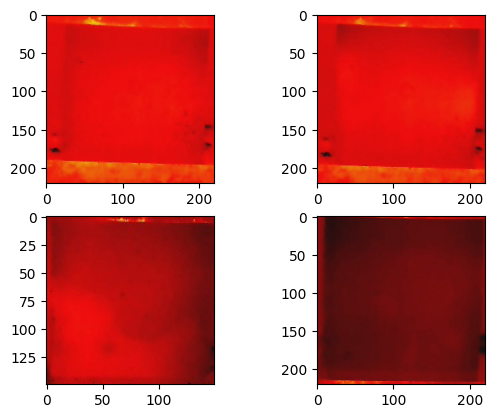

In [ ]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Negative/', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Negative/', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Negative/', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, '/content/ThermalDataset/Negative/', random_images[3])))

In [ ]:
print(cwd)

/content


In [ ]:
base_dir = cwd
files = os.listdir(f'{base_dir}/ThermalDataset/')

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/ThermalDataset/{folder_name}', train_dir)
create_training_data('Positive')
create_training_data('Negative')

In [ ]:
os.listdir('/content')

['.config',
 'ThermalDataset',
 'kbvssyjhcj-1',
 '.ipynb_checkpoints',
 'drive',
 'train',
 'kbvssyjhcj-1.zip']

In [ ]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [ ]:
os.listdir('/content')

['.config',
 'ThermalDataset',
 'kbvssyjhcj-1',
 'val',
 '.ipynb_checkpoints',
 'drive',
 'train',
 'kbvssyjhcj-1.zip']

In [ ]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"


positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)
positive_val_files = os.listdir(positive_val)
negative_val_files = os.listdir(negative_val)

In [ ]:
print(len(positive_files), len(negative_files))
print(len(positive_val_files), len(negative_val_files))

5494 5651
0 0


In [ ]:
for f in positive_files:
    if random.random() > 0.80:
        shutil.move(f'{positive_train}/{f}', positive_val)
for f in negative_files:
    if random.random() > 0.80:
        shutil.move(f'{negative_train}/{f}', negative_val)

In [ ]:
positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)
positive_val_files = os.listdir(positive_val)
negative_val_files = os.listdir(negative_val)

In [ ]:
print(len(positive_files), len(negative_files))
print(len(positive_val_files), len(negative_val_files))

4404 4511
1090 1140


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

# there are three channels in an RGB IMAGE.
# 1. red
# 2. green
# 3. blue

In [ ]:
from torchvision import transforms

In [ ]:
## Define data augmentation and transforms
chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=227),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(227),
        transforms.CenterCrop(227),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
import tensorflow as tf

# Check if TPU is available
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
print('Running on TPU:', tpu.master())

# Connect to the TPU cluster
tf.config.experimental_connect_to_cluster(tpu)

# Initialize the TPU system
tf.tpu.experimental.initialize_tpu_system(tpu)

# Create a distribution strategy
strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU: grpc://10.84.72.178:8470


In [ ]:
train_loader, train_size, class_names = load_dataset('train', 8)
print("Train Data Set size is: ", train_size)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  8915
Class Names are:  ['Negative', 'Positive']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([8, 3, 227, 227]) torch.Size([8])


In [ ]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

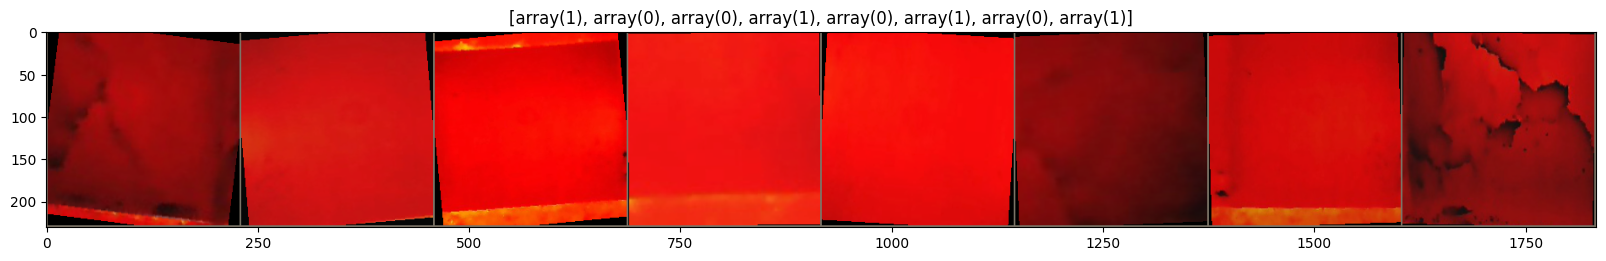

In [ ]:
import torchvision
# Grab some of the training data to visualize
inputs, classes = next(iter(train_loader))
# class_names = chosen_datasets['train'].classes
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

idx_to_class = {0:'Negative', 1:'Positive'}
plt.figure(figsize=(20,10))
imshow(out, title=[x.data.numpy() for x in classes])

In [ ]:
## Load pretrained model
# residual networks. These are a special type of neural networks in contrast to fully connected networks.
# this solves the problem of vanishing gradients.
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

## Change the final layer of the resnet model
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

# Linear layer is an alias for fully connected layer.
# Convert model to be used on GPU
resnet50 = resnet50.to(device)

from torchsummary import summary
print(summary(resnet50, (3, 227, 227)))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           9,408
       BatchNorm2d-2         [-1, 64, 114, 114]             128
              ReLU-3         [-1, 64, 114, 114]               0
         MaxPool2d-4           [-1, 64, 57, 57]               0
            Conv2d-5           [-1, 64, 57, 57]           4,096
       BatchNorm2d-6           [-1, 64, 57, 57]             128
              ReLU-7           [-1, 64, 57, 57]               0
            Conv2d-8           [-1, 64, 57, 57]          36,864
       BatchNorm2d-9           [-1, 64, 57, 57]             128
             ReLU-10           [-1, 64, 57, 57]               0
           Conv2d-11          [-1, 256, 57, 57]          16,384
      BatchNorm2d-12          [-1, 256, 57, 57]             512
           Conv2d-13          [-1, 256, 57, 57]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Define Optimizer and Loss Function
# learning rate decay. As we train the model, we can decide to change the learning rate dynamically.
# the schedular helps us in doing that.
#@ IN THE FIRST epoch, the learning rate was 0.1, then the learning rate in epoch 4 would be 0.01.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters())
# optimizer = optim.SGD(resnet50.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 3 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
dataloaders = {}
dataset_sizes = {}
batch_size = 256
dataloaders['train'], dataset_sizes['train'], class_names = load_dataset('train', batch_size)
dataloaders['val'], dataset_sizes['val'], _ = load_dataset('val', batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}

In [ ]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                scheduler.step()  # Adjust learning rate here, after setting to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')
            # training starts...
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()
                # Time to carry out the forward training pass
                # We only need to log the loss stats if we are in the training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # This computes the class that the model belongs to...
                    _, preds = torch.max(outputs, 1)
                    # Compute the loss here...
                    # We compute the difference between true label and the predicted output...
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in the training phase
                    if phase == 'train':
                        loss.backward()  # This is the back-propagation step. We
                        # minimize our model loss and optimize the model in this phase
                        optimizer.step()  # Optimizer updates the model parameters...

                # We want variables to hold the loss statistics
                # Combine our model losses and compute the wrongly classified examples
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            # Compute the loss and accuracy for each of our epochs
            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/5
----------
Iterating through data...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5165 Acc: 0.7468
Iterating through data...
val Loss: 0.2988 Acc: 0.8807

Epoch 1/5
----------
Iterating through data...
train Loss: 0.3416 Acc: 0.8517
Iterating through data...
val Loss: 0.2454 Acc: 0.8969

Epoch 2/5
----------
Iterating through data...
train Loss: 0.3026 Acc: 0.8769
Iterating through data...
val Loss: 0.2486 Acc: 0.8933

Epoch 3/5
----------
Iterating through data...
train Loss: 0.2958 Acc: 0.8759
Iterating through data...
val Loss: 0.2355 Acc: 0.9027

Epoch 4/5
----------
Iterating through data...
train Loss: 0.2960 Acc: 0.8785
Iterating through data...
val Loss: 0.2447 Acc: 0.8901

Epoch 5/5
----------
Iterating through data...
train Loss: 0.2871 Acc: 0.8819
Iterating through data...
val Loss: 0.2303 Acc: 0.9054

Training complete in 279m 35s
Best val Acc: 0.905381


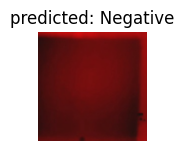

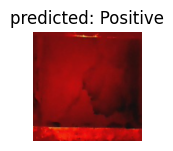

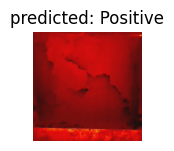

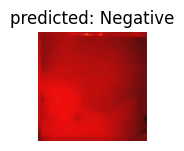

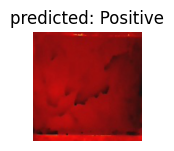

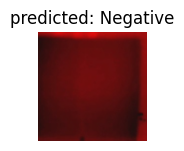

In [ ]:
base_model = train_model(resnet50, criterion, optimizer, exp_lr_scheduler, num_epochs=6)
visualize_model(base_model)
plt.show()
# an epoch is the total time during which one training step completes. In other words, it is the total
# time that our model takes to process the input data once...

In [ ]:
def predict(model, test_image, print_class = False):
     # it uses the model to predict on test_image...
    transform = chosen_transforms['val']

    test_image_tensor = transform(test_image)
    if torch.cuda.is_available(): # checks if we have a gpu available
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        # this computes the output of the model
        out = model(test_image_tensor)
        # this computes the probability of each classes.
        ps = torch.exp(out)
        # we choose the top class. That is, the class with highest probability
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=220, width=220, save_crops = False):
    im = cv2.imread(input_image)
    if im is None:
        raise Exception("Failed to load the image.")

    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(base_model,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Negative':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA)
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('real_images', folder_name)):
                    os.makedirs(os.path.join('real_images', folder_name))
                filename = os.path.join('real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [ ]:
import torch

# Assuming your model is named 'base_model'
torch.save(base_model.state_dict(), 'base_model.pth')



In [ ]:
from google.colab import files
files.download('base_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

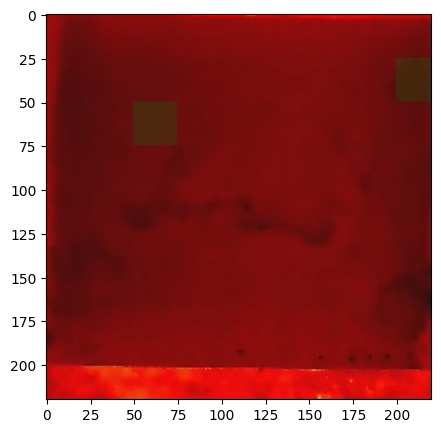

In [ ]:
plt.figure(figsize=(5,5))
output_image = predict_on_crops('/content/train/Positive/2_03063.png', 25, 25)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

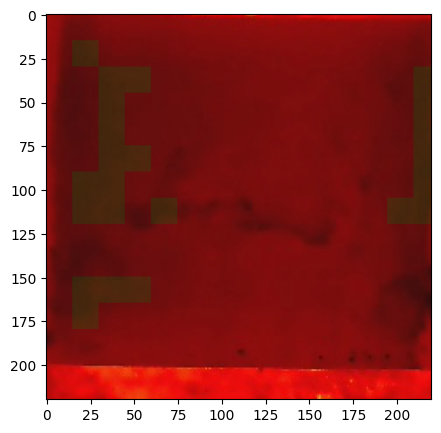

In [ ]:
plt.figure(figsize=(5,5))
output_image = predict_on_crops('/content/train/Positive/2_03063.png',15,15)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

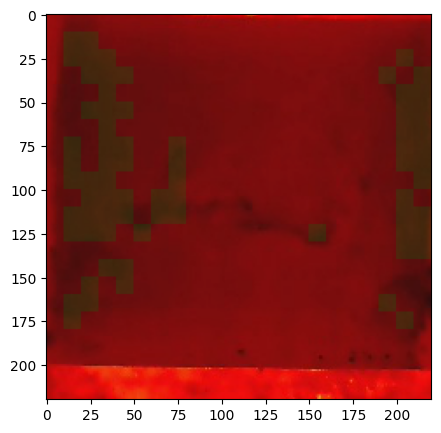

In [ ]:
plt.figure(figsize=(5,5))
output_image = predict_on_crops('/content/train/Positive/2_03063.png',10,10)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

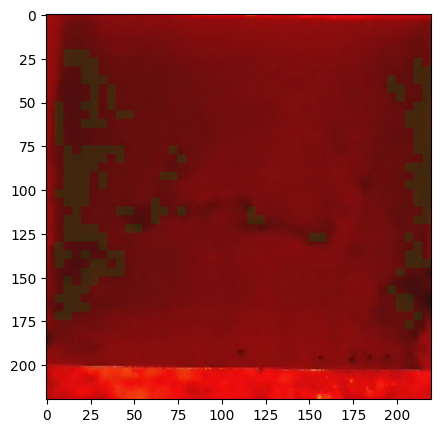

In [ ]:
plt.figure(figsize=(5,5))
output_image = predict_on_crops('/content/train/Positive/2_03063.png', 5,5)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

In [ ]:
import zipfile

with zipfile.ZipFile('/content/test.zip', 'r') as main_zip:
    main_zip.extractall('/content/')

In [ ]:
import os

file_path = '/content/test/.DS_Store'

try:
    os.remove(file_path)
    print(f'{file_path} removed successfully!')
except FileNotFoundError:
    print(f'{file_path} not found.')
except Exception as e:
    print(f'An error occurred: {e}')


/content/test/.DS_Store removed successfully!


In [ ]:
# to remove a directory and its contents
import shutil
directory_path = '/content/output_images'
shutil.rmtree(directory_path)

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load image from file path
def load_image(file_path):
    return Image.open(file_path).convert('RGB')


def store_images_in_folder(input_folder, output_folder):
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get a list of all files in the input folder
        input_images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

        for input_image_filename in input_images:
            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder, input_image_filename)

            # Read input image
            input_image = cv2.imread(input_image_path)
            test_image = load_image(input_image_path)

            # Replace the following line with your model inference logic
            # This is just a placeholder to show the concept
            output_class = predict(base_model, test_image, print_class=True)
            if output_class == "Negative":
              output_image = input_image
            else:
              output_image = predict_on_crops(input_image_path,10,10)

            # Save input and output images
            output_filename = 'output_10' + input_image_filename
            output_image_path = os.path.join(output_folder, output_filename)

            cv2.imwrite(output_image_path, output_image)
            print(f"Images stored successfully:\nInput: {input_image_path}\nOutput: {output_image_path}")

        print("Processing complete for all images.")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_folder_path = '/content/test'
output_folder_path = '/content/output_images_10'
store_images_in_folder(input_folder_path, output_folder_path)


In [ ]:
import time

while True:
    print("Stayin' alive!")
    time.sleep(300)  # Sleep for 5 minutes

Stayin' alive!


KeyboardInterrupt: 

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load image from file path
def load_image(file_path):
    return Image.open(file_path).convert('RGB')


def store_images_in_folder(input_folder, output_folder):
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get a list of all files in the input folder
        input_images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

        for input_image_filename in input_images:
            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder, input_image_filename)

            # Read input image
            input_image = cv2.imread(input_image_path)
            test_image = load_image(input_image_path)

            # Replace the following line with your model inference logic
            # This is just a placeholder to show the concept
            output_class = predict(base_model, test_image, print_class=True)
            if output_class == "Negative":
              output_image = input_image
            else:
              output_image = predict_on_crops(input_image_path,15,15)

            # Save input and output images
            output_filename = 'output_15' + input_image_filename
            output_image_path = os.path.join(output_folder, output_filename)

            cv2.imwrite(output_image_path, output_image)
            print(f"Images stored successfully:\nInput: {input_image_path}\nOutput: {output_image_path}")

        print("Processing complete for all images.")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_folder_path = '/content/test'
output_folder_path = '/content/output_images_15'
store_images_in_folder(input_folder_path, output_folder_path)


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load image from file path
def load_image(file_path):
    return Image.open(file_path).convert('RGB')


def store_images_in_folder(input_folder, output_folder):
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get a list of all files in the input folder
        input_images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

        for input_image_filename in input_images:
            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder, input_image_filename)

            # Read input image
            input_image = cv2.imread(input_image_path)
            test_image = load_image(input_image_path)

            # Replace the following line with your model inference logic
            # This is just a placeholder to show the concept
            output_class = predict(base_model, test_image, print_class=True)
            if output_class == "Negative":
              output_image = input_image
            else:
              output_image = predict_on_crops(input_image_path,5,5)

            # Save input and output images
            output_filename = 'output_5' + input_image_filename
            output_image_path = os.path.join(output_folder, output_filename)

            cv2.imwrite(output_image_path, output_image)
            print(f"Images stored successfully:\nInput: {input_image_path}\nOutput: {output_image_path}")

        print("Processing complete for all images.")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_folder_path = '/content/test'
output_folder_path = '/content/output_images_5'
store_images_in_folder(input_folder_path, output_folder_path)


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load image from file path
def load_image(file_path):
    return Image.open(file_path).convert('RGB')


def store_images_in_folder(input_folder, output_folder):
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get a list of all files in the input folder
        input_images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

        for input_image_filename in input_images:
            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder, input_image_filename)

            # Read input image
            input_image = cv2.imread(input_image_path)
            test_image = load_image(input_image_path)

            # Replace the following line with your model inference logic
            # This is just a placeholder to show the concept
            output_class = predict(base_model, test_image, print_class=True)
            if output_class == "Negative":
              output_image = input_image
            else:
              output_image = predict_on_crops(input_image_path,20,20)

            # Save input and output images
            output_filename = 'output_5' + input_image_filename
            output_image_path = os.path.join(output_folder, output_filename)

            cv2.imwrite(output_image_path, output_image)
            print(f"Images stored successfully:\nInput: {input_image_path}\nOutput: {output_image_path}")

        print("Processing complete for all images.")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_folder_path = '/content/test'
output_folder_path = '/content/output_images_20'
store_images_in_folder(input_folder_path, output_folder_path)


In [ ]:
import shutil

shutil.make_archive("/content/output_images_20", 'zip', "/content/output_images_20")

'/content/output_images_20.zip'

In [ ]:
from google.colab import files

files.download("/content/output_images_10")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load image from file path
def load_image(file_path):
    return Image.open(file_path).convert('RGB')


def store_images_in_folder(input_folder, output_folder):
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get a list of all files in the input folder
        input_images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

        for input_image_filename in input_images:
            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder, input_image_filename)

            # Read input image
            input_image = cv2.imread(input_image_path)
            test_image = load_image(input_image_path)

            # Replace the following line with your model inference logic
            # This is just a placeholder to show the concept
            output_class = predict(base_model, test_image, print_class=True)
            if output_class == "Negative":
              output_image = input_image
            else:
              output_image = predict_on_crops(input_image_path,35,35)

            # Save input and output images
            output_filename = 'output_35' + input_image_filename
            output_image_path = os.path.join(output_folder, output_filename)

            cv2.imwrite(output_image_path, output_image)
            print(f"Images stored successfully:\nInput: {input_image_path}\nOutput: {output_image_path}")

        print("Processing complete for all images.")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_folder_path = '/content/test'
output_folder_path = '/content/output_images_35'
store_images_in_folder(input_folder_path, output_folder_path)


In [ ]:
import shutil

shutil.make_archive("/content/output_images_35", 'zip', "/content/output_images_35")

'/content/output_images_25.zip'

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Function to load image from file path
def load_image(file_path):
    return Image.open(file_path).convert('RGB')


def store_images_in_folder(input_folder, output_folder):
    try:
        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)

        # Get a list of all files in the input folder
        input_images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]

        for input_image_filename in input_images:
            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder, input_image_filename)

            # Read input image
            input_image = cv2.imread(input_image_path)
            test_image = load_image(input_image_path)

            # Replace the following line with your model inference logic
            # This is just a placeholder to show the concept
            output_class = predict(base_model, test_image, print_class=True)
            if output_class == "Negative":
              output_image = input_image
            else:
              output_image = predict_on_crops(input_image_path,30,30)

            # Save input and output images
            output_filename = 'output_30' + input_image_filename
            output_image_path = os.path.join(output_folder, output_filename)

            cv2.imwrite(output_image_path, output_image)
            print(f"Images stored successfully:\nInput: {input_image_path}\nOutput: {output_image_path}")

        print("Processing complete for all images.")

    except Exception as e:
        print(f"Error: {e}")

# Example usage
input_folder_path = '/content/test'
output_folder_path = '/content/output_images_30'
store_images_in_folder(input_folder_path, output_folder_path)


In [ ]:
import shutil

shutil.make_archive("/content/output_images_30", 'zip', "/content/output_images_30")

'/content/output_images_30.zip'

In [ ]:
import time

while True:
    print("Stayin' alive!")
    time.sleep(300)  # Sleep for 5 minutes

Stayin' alive!


KeyboardInterrupt: 

In [ ]:
import shutil
shutil.make_archive("/content/output_images_5", 'zip', "/content/output_images_5")
shutil.make_archive("/content/output_images_10", 'zip', "/content/output_images_10")
shutil.make_archive("/content/output_images_15", 'zip', "/content/output_images_15")
shutil.make_archive("/content/output_images_20", 'zip', "/content/output_images_20")
shutil.make_archive("/content/output_images_25", 'zip', "/content/output_images_25")
shutil.make_archive("/content/output_images_30", 'zip', "/content/output_images_30")
shutil.make_archive("/content/output_images_35", 'zip', "/content/output_images_35")

'/content/output_images_35.zip'